In [2]:
import sys, torch
print(sys.executable)
print("torch:", torch.__version__, "| cuda_available:", torch.cuda.is_available())


d:\Hackathon\disease_modelTrainer\venv\Scripts\python.exe
torch: 2.8.0+cpu | cuda_available: False


classes: ['Early_blight', 'Late_blight', 'healthy']


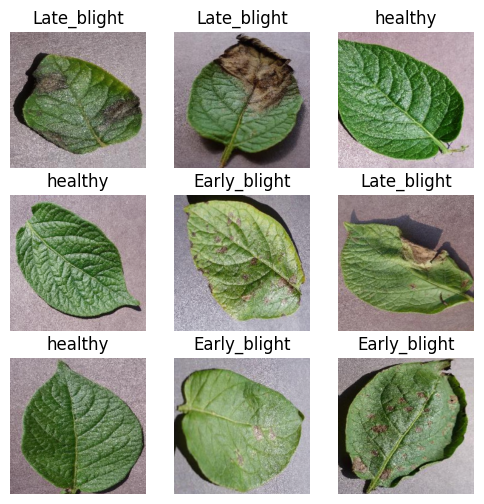

In [4]:
from fastai.vision.all import *

path = Path('Data')  # capital D

dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2, seed=42,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(
        size=224,
        flip_vert=True,
        max_rotate=15,
        max_warp=0.1,
        max_lighting=0.2,   # <-- replaces brightness/contrast
        p_affine=0.75,
        p_lighting=0.75
    ),
    bs=16,
    num_workers=0          # Windows-friendly
)
print("classes:", dls.vocab)
dls.show_batch(max_n=9, figsize=(6,6))



In [6]:
# rebuild the Learner with the correct metric
learn = vision_learner(
    dls, 'resnet34',
    metrics=[accuracy, F1Score(average='macro')]
)
learn.fine_tune(5, base_lr=3e-4)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.158863,0.408375,0.846512,0.761458,01:26


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.658092,0.342841,0.867442,0.791285,01:56
1,0.478054,0.263477,0.897674,0.825374,02:07
2,0.434828,0.225670,0.923256,0.871039,01:57
3,0.390801,0.217177,0.913953,0.856858,02:14
4,0.414937,0.213930,0.923256,0.868434,02:06


Accuracy: 0.9232558139534883
Macro-F1: 0.8684338162746016
              precision    recall  f1-score   support

Early_blight       0.97      0.95      0.96       198
 Late_blight       0.95      0.90      0.92       201
     healthy       0.61      0.87      0.72        31

    accuracy                           0.92       430
   macro avg       0.84      0.91      0.87       430
weighted avg       0.93      0.92      0.93       430



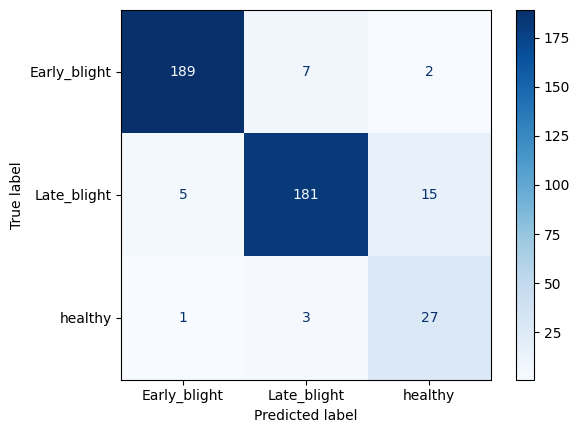

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np

valid_dl = dls.valid.new(shuffle=False, drop_last=False, bs=16, num_workers=0)
preds, targs = learn.get_preds(dl=valid_dl, with_loss=False)

y_true = targs.cpu().numpy()
y_pred = preds.argmax(1).cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro-F1:", f1_score(y_true, y_pred, average='macro'))
print(classification_report(y_true, y_pred, target_names=dls.vocab))

cm = confusion_matrix(y_true, y_pred, labels=range(len(dls.vocab)))
ConfusionMatrixDisplay(cm, display_labels=dls.vocab).plot(cmap="Blues");





In [11]:
learn.export('potato_3cls.pkl')


Classes: ['Early_blight', 'Late_blight', 'healthy']
Image: Data\Early_blight\001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG
Predicted: Early_blight  |  Confidence: 99.97%
Top-3: [('Early_blight', '99.97%'), ('healthy', '0.02%'), ('Late_blight', '0.00%')]


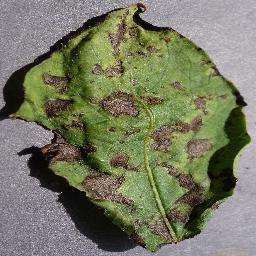

In [15]:
from fastai.vision.all import *
from pathlib import Path
from IPython.display import display

# 1) Load the model from Data/
model_path = Path('Data/potato_3cls.pkl')   # <-- note the Data/ prefix
assert model_path.exists(), f"Can't find: {model_path.resolve()}"
learn = load_learner(model_path)

# 2) Pick any image under Data/<class>/ and predict
data_root = Path('Data')
exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
img_paths = [p for p in data_root.rglob('*') if p.suffix.lower() in exts]
assert img_paths, "No images found under Data/. Add images to Data/<class>/ first."

img_path = img_paths[0]                         # choose one image
img = PILImage.create(img_path)

pred, idx, probs = learn.predict(img)
top3 = sorted(zip(learn.dls.vocab, probs.tolist()), key=lambda kv: kv[1], reverse=True)[:3]

print("Classes:", learn.dls.vocab)
print("Image:", img_path)
print(f"Predicted: {pred}  |  Confidence: {float(probs[idx]):.2%}")
print("Top-3:", [(k, f"{v:.2%}") for k, v in top3])
display(img.to_thumb(320, 320))





In [22]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np, torch

# 1) Valid preds
valid_dl = dls.valid.new(shuffle=False, drop_last=False, bs=16, num_workers=0)
preds, targs = learn.get_preds(dl=valid_dl, with_loss=False)

# 2) Make sure we have probs
probs = preds if torch.allclose(preds.sum(1).mean(), torch.tensor(1.0), atol=1e-2) else preds.softmax(dim=1)
labels = list(dls.vocab)
healthy_name = next(l for l in labels if l.lower()=='healthy')
h = labels.index(healthy_name)

y_true_bin = (targs.cpu().numpy()==h).astype(int)
scores = probs[:, h].cpu().numpy()

prec, rec, thr = precision_recall_curve(y_true_bin, scores)

TARGET_PREC = 0.90  # <-- adjust target precision here
if (prec >= TARGET_PREC).any():
    i = np.where(prec >= TARGET_PREC)[0][0]
else:
    i = int(np.argmax(prec))  # best attainable precision
healthy_thr = float(thr[max(0, i-1)])
print(f"Chosen healthy threshold: {healthy_thr:.3f} (≈ precision {prec[i]:.2f}, recall {rec[i]:.2f})")



Chosen healthy threshold: 0.804 (≈ precision 0.91, recall 0.68)


In [23]:
HEALTHY_THR = healthy_thr  # from previous cell

def predict_with_threshold(img, learn):
    pred, idx, probs = learn.predict(img)
    labels = learn.dls.vocab
    probs = probs.detach().cpu()

    top_idx = int(probs.argmax())
    # if top-1 is healthy but below threshold, switch to best non-healthy
    if labels[top_idx].lower() == 'healthy' and float(probs[top_idx]) < HEALTHY_THR:
        pr = probs.clone()
        pr[top_idx] = 0.0
        top_idx = int(pr.argmax())
        pred = labels[top_idx]
    return str(pred), float(probs[top_idx])



Healthy precision BEFORE: 0.614
Healthy precision AFTER : 0.875

With thresholded preds:
              precision    recall  f1-score   support

Early_blight       0.95      0.96      0.95       198
 Late_blight       0.92      0.94      0.93       201
     healthy       0.88      0.68      0.76        31

    accuracy                           0.93       430
   macro avg       0.91      0.86      0.88       430
weighted avg       0.93      0.93      0.93       430



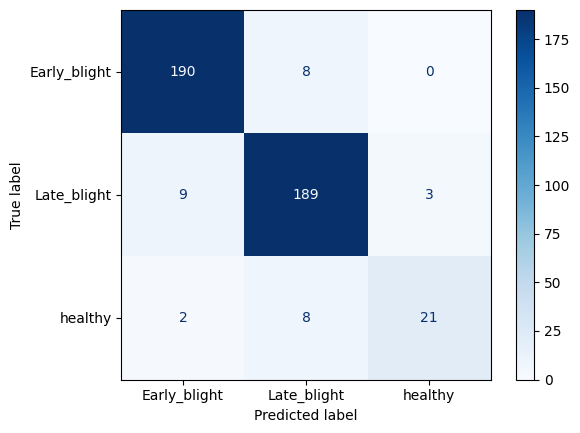

In [26]:
# assumes you already have: preds, targs, dls, and HEALTHY_THR (from earlier PR-curve step)
import numpy as np, torch
from sklearn.metrics import precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = list(dls.vocab)
healthy_name = next(l for l in labels if l.lower()=='healthy')
h = labels.index(healthy_name)

# BEFORE: plain argmax
y_true = targs.cpu().numpy()
probs = preds if torch.allclose(preds.sum(1).mean(), torch.tensor(1.0), atol=1e-2) else preds.softmax(dim=1)
y_pred_before = probs.argmax(1).cpu().numpy()
prec_before = precision_score(y_true, y_pred_before, labels=[h], average=None)[0]

# AFTER: apply Healthy threshold
def apply_thr_row(pr):
    pr = pr.clone()
    top = int(pr.argmax())
    if labels[top].lower()=='healthy' and float(pr[top]) < HEALTHY_THR:
        pr[top] = 0.0
        top = int(pr.argmax())
    return top

y_pred_after = np.array([apply_thr_row(p.cpu()) for p in probs])
prec_after  = precision_score(y_true, y_pred_after, labels=[h], average=None)[0]

print(f"Healthy precision BEFORE: {prec_before:.3f}")
print(f"Healthy precision AFTER : {prec_after:.3f}")

# (optional) full report + confusion matrix with thresholded preds
print("\nWith thresholded preds:")
print(classification_report(y_true, y_pred_after, target_names=labels))
cm = confusion_matrix(y_true, y_pred_after, labels=range(len(labels)))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap="Blues");



Chosen HEALTHY_THR=0.714  -> precision≈0.86, recall≈0.81
Healthy precision BEFORE: 0.614 | recall BEFORE: 0.871
Healthy precision AFTER : 0.833 | recall AFTER : 0.806

Classification report (AFTER threshold):
              precision    recall  f1-score   support

Early_blight       0.95      0.96      0.95       198
 Late_blight       0.94      0.93      0.93       201
     healthy       0.83      0.81      0.82        31

    accuracy                           0.93       430
   macro avg       0.91      0.90      0.90       430
weighted avg       0.93      0.93      0.93       430



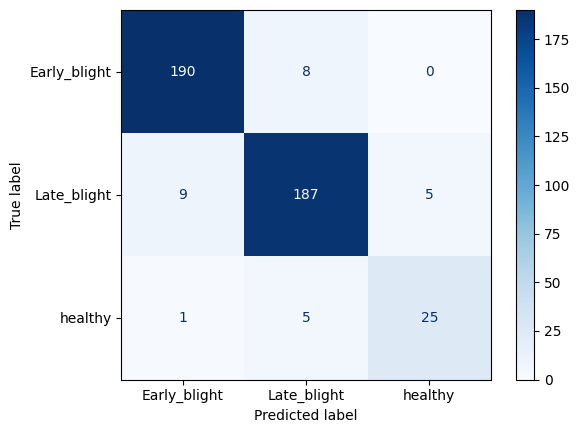

In [30]:
import numpy as np, torch
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

TARGET_REC = 0.80   # set the minimum recall you want for 'healthy'

# Use existing preds/targs if you already computed them; else compute on valid quickly
if 'preds' in globals() and 'targs' in globals():
    P, T = preds, targs
else:
    valid_dl = dls.valid.new(shuffle=False, drop_last=False, bs=16, num_workers=0)
    P, T = learn.get_preds(dl=valid_dl, with_loss=False)

probs = P if torch.allclose(P.sum(1).mean(), torch.tensor(1.0), atol=1e-2) else P.softmax(dim=1)
labels = list(dls.vocab)
h = labels.index(next(l for l in labels if l.lower()=='healthy'))

y_true = T.cpu().numpy()
y_bin  = (y_true == h).astype(int)
scores = probs[:, h].detach().cpu().numpy()

prec, rec, thr = precision_recall_curve(y_bin, scores)

# pick threshold that achieves TARGET_REC with highest precision
mask = rec >= TARGET_REC
if mask.any():
    cand = np.where(mask)[0]
    best = cand[np.argmax(prec[cand])]
else:
    # can't reach that recall with this model; fall back to best F1
    F1 = 2*prec*rec/(prec+rec+1e-9)
    best = int(np.argmax(F1))

HEALTHY_THR = float(thr[max(0, best-1)])
print(f"Chosen HEALTHY_THR={HEALTHY_THR:.3f}  -> precision≈{prec[best]:.2f}, recall≈{rec[best]:.2f}")

# apply threshold and compare
def apply_thr_row(pr, thr=HEALTHY_THR):
    pr = pr.clone()
    top = int(pr.argmax())
    if labels[top].lower()=='healthy' and float(pr[top]) < thr:
        pr[top] = 0.0
        top = int(pr.argmax())
    return top

y_pred_before = probs.argmax(1).cpu().numpy()
y_pred_after  = np.array([apply_thr_row(p.cpu()) for p in probs])

def pr_re(y_true, y_pred, cidx):
    tp = ((y_true==cidx) & (y_pred==cidx)).sum()
    pp = (y_pred==cidx).sum()
    p  = 0.0 if pp==0 else tp/pp
    ppos = (y_true==cidx).sum()
    r  = 0.0 if ppos==0 else tp/ppos
    return p, r

p_b, r_b = pr_re(y_true, y_pred_before, h)
p_a, r_a = pr_re(y_true, y_pred_after,  h)
print(f"Healthy precision BEFORE: {p_b:.3f} | recall BEFORE: {r_b:.3f}")
print(f"Healthy precision AFTER : {p_a:.3f} | recall AFTER : {r_a:.3f}\n")

print("Classification report (AFTER threshold):")
print(classification_report(y_true, y_pred_after, target_names=labels))

cm = confusion_matrix(y_true, y_pred_after, labels=range(len(labels)))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap="Blues");
